In [ ]:
import torch, math, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from scipy.stats import kde
import matplotlib.pyplot as plt

In [ ]:
from torch.utils.data import DataLoader
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


100%|██████████| 170498071/170498071 [00:02<00:00, 76710828.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#Create a control model with 3 layers

class StandardModel(nn.Module):
    def __init__(self):
        super(StandardModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(), nn.Linear(4096, 512), nn.Dropout(0.5), nn.Linear(512, 256),
            nn.Dropout(0.5), nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.model(x)





In [ ]:
def train(model, device, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy, test_loss


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = StandardModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

target_accuracy = 87
epochs = 0
accuracy = 0
epoch_limit = 50
standard_loss_list = []
standard_test_accuracy = []

torch.cuda.empty_cache()
while accuracy < target_accuracy and epochs <= epoch_limit:
    epochs += 1
    train(model, device, train_loader, optimizer)
    accuracy, test_loss = test(model, device, test_loader)
    standard_test_accuracy.append(accuracy)
    standard_loss_list.append(test_loss)
    print(f'Epoch: {epochs}, Test Accuracy: {accuracy:.2f}%')

print(f'Converged in {epochs} epochs')


Epoch: 1, Test Accuracy: 55.82%
Epoch: 2, Test Accuracy: 72.57%
Epoch: 3, Test Accuracy: 77.19%
Epoch: 4, Test Accuracy: 80.50%
Epoch: 5, Test Accuracy: 77.49%
Epoch: 6, Test Accuracy: 81.43%
Epoch: 7, Test Accuracy: 82.66%
Epoch: 8, Test Accuracy: 83.82%
Epoch: 9, Test Accuracy: 84.90%
Epoch: 10, Test Accuracy: 84.25%
Epoch: 11, Test Accuracy: 83.49%
Epoch: 12, Test Accuracy: 85.35%
Epoch: 13, Test Accuracy: 84.68%
Epoch: 14, Test Accuracy: 85.21%
Epoch: 15, Test Accuracy: 81.13%
Epoch: 16, Test Accuracy: 85.05%
Epoch: 17, Test Accuracy: 84.48%
Epoch: 18, Test Accuracy: 83.58%
Epoch: 19, Test Accuracy: 85.02%
Epoch: 20, Test Accuracy: 84.74%
Epoch: 21, Test Accuracy: 83.81%
Epoch: 22, Test Accuracy: 85.01%
Epoch: 23, Test Accuracy: 84.26%
Epoch: 24, Test Accuracy: 84.80%
Epoch: 25, Test Accuracy: 84.79%
Epoch: 26, Test Accuracy: 85.23%
Epoch: 27, Test Accuracy: 84.88%
Epoch: 28, Test Accuracy: 84.61%
Epoch: 29, Test Accuracy: 84.14%
Epoch: 30, Test Accuracy: 84.82%
Epoch: 31, Test Acc

In [ ]:

test_accuracy = [55.82, 72.57, 77.19, 80.5, 77.49, 81.43, 82.66, 83.82, 84.9, 84.25, 83.49, 85.35, 84.68, 85.21, 81.13, 85.05, 84.48, 83.58, 85.02, 84.74, 83.81, 85.01, 84.26, 84.8, 84.79, 85.23, 84.88, 84.61, 84.14, 84.82, 84.64, 85.12, 85.66, 85.22, 85.48, 83.92, 84.12, 84.51, 85.22, 84.74, 84.86, 85.35, 85.01, 84.61, 85.24, 85.29, 84.21, 86.07, 85.43, 84.26, 84.01]



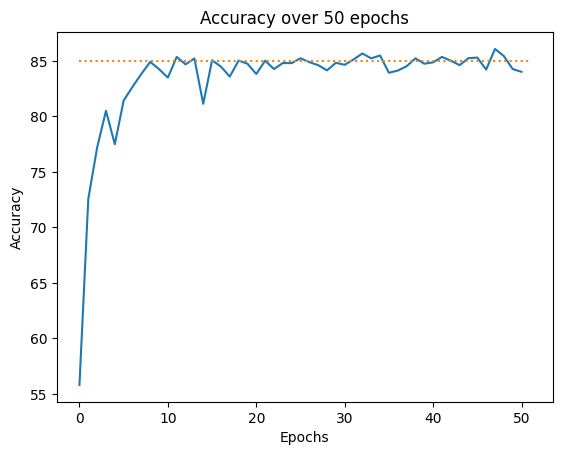

In [ ]:
sns.lineplot(test_accuracy)
plt.title("Accuracy over 50 epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
x = np.linspace(0, 51, 51)
y = np.full(51, 85)
plt.plot(x, y, linestyle = 'dotted')
plt.savefig('firstgraph.png',dpi = 800)

In [ ]:
#Create a model with no batch norm

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(), nn.Linear(4096, 512), nn.Dropout(0.5), nn.Linear(512, 256),
            nn.Dropout(0.5), nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.model(x)





In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BaseModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

target_accuracy = 87
epochs = 0
accuracy = 0
epoch_limit = 50
standard_loss_list = []
standard_test_accuracy = []

torch.cuda.empty_cache()
while accuracy < target_accuracy and epochs <= epoch_limit:
    epochs += 1
    train(model, device, train_loader, optimizer)
    accuracy, test_loss = test(model, device, test_loader)
    standard_test_accuracy.append(accuracy)
    standard_loss_list.append(test_loss)
    print(f'Epoch: {epochs}, Test Accuracy: {accuracy:.2f}%')

print(f'Converged in {epochs} epochs')


Epoch: 1, Test Accuracy: 57.63%
Epoch: 2, Test Accuracy: 66.61%
Epoch: 3, Test Accuracy: 71.76%
Epoch: 4, Test Accuracy: 72.91%
Epoch: 5, Test Accuracy: 73.63%
Epoch: 6, Test Accuracy: 75.94%
Epoch: 7, Test Accuracy: 76.69%
Epoch: 8, Test Accuracy: 76.14%
Epoch: 9, Test Accuracy: 75.10%
Epoch: 10, Test Accuracy: 73.96%
Epoch: 11, Test Accuracy: 75.72%
Epoch: 12, Test Accuracy: 75.13%
Epoch: 13, Test Accuracy: 75.87%
Epoch: 14, Test Accuracy: 75.43%
Epoch: 15, Test Accuracy: 75.72%
Epoch: 16, Test Accuracy: 75.83%
Epoch: 17, Test Accuracy: 75.84%
Epoch: 18, Test Accuracy: 75.42%
Epoch: 19, Test Accuracy: 75.85%
Epoch: 20, Test Accuracy: 76.30%
Epoch: 21, Test Accuracy: 75.65%
Epoch: 22, Test Accuracy: 75.37%
Epoch: 23, Test Accuracy: 74.58%
Epoch: 24, Test Accuracy: 75.33%
Epoch: 25, Test Accuracy: 74.36%
Epoch: 26, Test Accuracy: 74.53%
Epoch: 27, Test Accuracy: 74.94%
Epoch: 28, Test Accuracy: 75.49%
Epoch: 29, Test Accuracy: 74.78%
Epoch: 30, Test Accuracy: 76.39%
Epoch: 31, Test Acc